# 잉스타 

In [4]:
!pip install selenium
!pip install psycopg2-binary
!pip install psycopg2
!pip install pyautogui

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached pyperclip-1.8.2-py3-none-any.whl
  Created wheel for pyautogui: filename=PyAutoGUI-0.9.53-py3-none-any.whl size=36613 sha256=45b46e4dcabae0c8d0e60adeeac27e271b00aa21a73127b0d420838fef7b7a85
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\d8\97\e4\d2edca92a87d3b5fbfb527264750a17b4ba297b9a7cab6e67f
  Created wheel for pygetwindow: filename=P

In [1]:
# 필요 패키지 호출
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver import ActionChains
from bs4 import BeautifulSoup
import selenium
import time
import urllib.parse
import re
import pyautogui
import random
import psycopg2
import pandas as pd
import urllib.request
import json

### DB 불러오기

In [19]:
# DB 생성
conn_str = "host=localhost dbname=postgres user=postgres password=admin port=5433"

try:
    conn = psycopg2.connect(conn_str)
    print("=== 접속 성공 =====")
# except:
#   print("접속오류 !!")

except psycopg2.DatabaseError as db_err:
    print("접속오류 !!")
    print(db_err)
    
cur = conn.cursor() # cursor 인스턴스 : 데이터 조작용 생성


=== 접속 성공 =====


### instagram 크롤링을 위한 함수 정의 및 준비

In [20]:
## 리스트 
        
CAMPING_dic = {'#캠핑':0, '#캠핑요리':0, '#캠핑용품':0, '#캠핑소품':0, '#캠핑그램':0, '#캠퍼':0, '#캠린이':0, '#감성캠핑':0, 
'#차박':0, '#글램핑':0, '#오토캠핑':0, '#카라반캠핑':0, '#카라반':0, '#노지캠핑':0, '#오지캠핑':0,
'#캠핑요리':0, '#캠핑음식':0, '#캠핑스타그램':0, '#캠핑장':0, '#캠핑카':0, '#불멍':0, '#백패커':0}

camping = list(CAMPING_dic.keys())

Camping_ls = []
for i in camping:
        Camping_ls.append(i.replace('#',''))

In [21]:
Camping_ls

['캠핑',
 '캠핑요리',
 '캠핑용품',
 '캠핑소품',
 '캠핑그램',
 '캠퍼',
 '캠린이',
 '감성캠핑',
 '차박',
 '글램핑',
 '오토캠핑',
 '카라반캠핑',
 '카라반',
 '노지캠핑',
 '오지캠핑',
 '캠핑음식',
 '캠핑스타그램',
 '캠핑장',
 '캠핑카',
 '불멍',
 '백패커']

In [2]:
# 함수 정의 : 검색어 조건에 따른 url 생성
def insta_searching(word):
    url = f"https://www.instagram.com/explore/tags/{word}"
    return url

In [3]:
# 함수정의 : 열린 페이지에서 첫번째 게시물 클릭 + sleep 메소드 통하여 시차 두기
def select_first(driver):
    first = driver.find_elements_by_css_selector('div._9AhH0')[0]
    first.click()
    time.sleep(random.randint(2,5))

In [4]:
# 함수 정의 : 본문 내용, 작성일자, 좋아요 수, 해시태그 가져오기
import re
from bs4 import BeautifulSoup

def get_content(driver):
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    
    # 본문 내용 
    try:
        content = soup.select('div.MOdxS > span')[0].text
    except:
        content = ' '
        
    # 해시태그 
    tag = re.findall(r'#[^\s#,\\]+', content)  
    # 작성일자 
    date = soup.select('time._1o9PC')[0]['datetime'][:10]
    # 좋아요
    try:
        like = soup.select('div.fDxYl > span')[0].text
    except:
        like = 0
    # 댓글에 달린 id count
    ids  = len(driver.find_elements_by_css_selector('div.C4VMK > h3 > div > span > a'))


    return content, tag, date, like , ids
    # results = [content, tags, date, like]
    # return results

In [5]:
def reple(): # 댓글 플러스 버튼 누르기  
    while True:
        try :
            button = driver.find_element_by_css_selector('body > div.RnEpo._Yhr4 > div.pbNvD.QZZGH.bW6vo > div > article > div > div.HP0qD > div > div > div.eo2As > div.EtaWk > ul > li > div > button')
            button.click()
            time.sleep(3)
        except : 
            break

In [6]:
def re_reple(): # 대댓글 버튼 누르기

    buttons = driver.find_elements_by_css_selector('li > ul > li > div > button')

    for button in buttons:
        button.send_keys(Keys.ENTER)
        time.sleep(2)

In [7]:
# 첫 번째 게시물 클릭 후 다음 게시물 클릭
def move_next(driver):
    right = driver.find_element_by_css_selector("div.l8mY4.feth3")
    right.click()
    time.sleep(random.randint(3,5))

### instagram 크롤링 코드
* time.sleep()을 이용하여 페이지 막히는 것 예방

In [29]:
# 크롤링 시작
"""
driver.get(url)을 통해 검색 페이지 접속하고,
target 변수에 크롤링할 게시글의 수를 바인딩
"""

# 인스타그램 로그인을 위한 계정 정보
username = pyautogui.prompt("인스타 아이디를 입력하세요.")
userpw = pyautogui.prompt("비밀번호를 입력하세요.")
time.sleep(3)

# 크롬 브라우저 열기
driver = webdriver.Chrome(executable_path='chromedriver')
driver.get(r'https://www.instagram.com')
# loginUrl = 'https://www.instagram.com/accounts/login/'
time.sleep(random.randint(3,5))

# login
driver.find_element_by_name('username').send_keys(username)
driver.find_element_by_name('password').send_keys(userpw)
time.sleep(random.randint(1,2))
driver.find_element_by_css_selector('button.sqdOP.L3NKy.y3zKF').click()
time.sleep(random.randint(3,5))

# 정보 나중에 저장하기 클릭하고 넘어가기
driver.find_element_by_css_selector('button.sqdOP.L3NKy.y3zKF').click()
time.sleep(random.randint(3,5))
# 설정 나중에하기 클릭하고 넘어가기
driver.find_element_by_css_selector('button.aOOlW.HoLwm').click()
time.sleep(random.randint(3,5))


# 게시물을 조회할 검색 키워드 입력 요청
word = pyautogui.prompt("검색어를 입력하세요.")
url = insta_searching(word)

# 검색 결과 페이지 열기
driver.get(url)
time.sleep(random.randint(5,8))

# 첫 번째 게시물 클릭
select_first(driver)

# 본격적으로 데이터 수집시작
# 수집할 게시물의 수 (최근 500개)

for n in range(10):
    print(n)
    
    try:
        # 날짜, 내용, 해시태그, 좋아요 수
        content,tags,date,like = get_content(driver)
        print(content)
        move_next(driver)
        
        if n < 10 or word == 'Camping_ls': #검색 시 관계있는 게시물
            if word == 'Camping_ls':
                try:
                    # 인기게시물 날짜, 내용, 해시태그, 좋아요 수  DB
                    print(date,content,tags,like)
                    cur.execute("INSERT INTO camping_x (day, content, tags, insta_like) VALUES (%s,%s,%s,%s);",(date,content,tags,like))
                    conn.commit()

                except:
                    conn.rollback()
                    print("--- DB error")
            else: #최신게시물
                try:
                    # 검색어 'Camping_ls'의 인기게시물에 대한 날짜, 내용, 해시태그, 좋아요 수  DB
                    cur.execute("INSERT INTO camping (day, content, tags, insta_like) VALUES (%s,%s,%s,%s);",(date,content,tags,like))
                    conn.commit()
                    
                except:
                    conn.rollback()
                    print("--- DB error")
                
            
        else:
            if tags != []:
                for me in tags:
                    for i in range(0,len(Camping_ls)):            
                        if camping[i] == me.upper():
                                Camping_ls[camping[i]] += 1
                            
            else:
                for j in range(0,len(Camping_ls)):
                    m = ''.join(char for char in camping[j] if  char.isalnum())
                    if m in content.upper():
                        Camping_ls[camping[j]] += 1

                            
    except:
        time.sleep(random.randint(1,2))
        move_next(driver)

# mbti별 언급된 수 DB
for no in camping:
    try:
        cur.execute("INSERT INTO count_ (camping,n) VALUES (%s,%s);",(no.replace('#',''),Camping_ls[no]))
        conn.commit()

    except:
        conn.rollback()
        print("--- DB error")

print(f'총 게시물 수 는 (최대1000개만 수집) : {n-8}')

SyntaxError: invalid syntax (Temp/ipykernel_1656/1609269039.py, line 44)

In [8]:
from datetime import date, timedelta, datetime
print('데이터 저장 시작' , datetime.today().strftime("%Y/%m/%d %H:%M:%S"))

데이터 저장 시작 2022/05/02 18:27:39


In [9]:
import openpyxl

In [10]:
# 크롤링 시작
"""
driver.get(url)을 통해 검색 페이지 접속하고,
target 변수에 크롤링할 게시글의 수를 바인딩
"""

# 인스타그램 로그인을 위한 계정 정보
username = pyautogui.prompt("인스타 아이디를 입력하세요.")
userpw = pyautogui.prompt("비밀번호를 입력하세요.")
time.sleep(3)

# 크롬 브라우저 열기
driver = webdriver.Chrome(executable_path='chromedriver')
driver.get(r'https://www.instagram.com')
# loginUrl = 'https://www.instagram.com/accounts/login/'
time.sleep(random.randint(3,5))

# login
driver.find_element_by_name('username').send_keys(username)
driver.find_element_by_name('password').send_keys(userpw)
time.sleep(random.randint(1,2))
driver.find_element_by_css_selector('button.sqdOP.L3NKy.y3zKF').click()
time.sleep(random.randint(3,5))

# 정보 나중에 저장하기 클릭하고 넘어가기
driver.find_element_by_css_selector('button.sqdOP.L3NKy.y3zKF').click()
time.sleep(random.randint(3,5))
# 설정 나중에하기 클릭하고 넘어가기
driver.find_element_by_css_selector('button.aOOlW.HoLwm').click()
time.sleep(random.randint(3,5))


# 게시물을 조회할 검색 키워드 입력 요청
word = pyautogui.prompt("검색어를 입력하세요.")
url = insta_searching(word)

# 검색 결과 페이지 열기
driver.get(url)
time.sleep(random.randint(5,8))

# 첫 번째 게시물 클릭
select_first(driver)

# 본격적으로 데이터 수집시작
## 본문, 날짜, 좋아요수, 해시태그, 댓글 전체수, 전체 댓글들
contents = []
dates = []
likes = []
tags = []
id_count = []
rp = []

# 검색범위 입력 요청
target = int(pyautogui.prompt("검색범위를 입력하세요."))


for n in range(target):
    print(n)
    try: # 날짜, 내용, 해시태그, 좋아요 수, id로 파악한 댓글수, 전체 댓글
        reple()
        re_reple()
        content, tag, date, like, ids = get_content(driver)
        print(date)
        contents.append(content)
        dates.append(date)
        likes.append(like)
        tags.append(tag)
        id_count.append(ids)
        rp_b=[]    # 전체 댓글을 따로 리스트로 넣지않으면 array가 달라져서 활용할수 없어진다.
        bbbb = len(driver.find_elements_by_css_selector('div > li > div > div > div.C4VMK > div.MOdxS > span'))
        for i in range(bbbb) :
            replies = driver.find_elements_by_css_selector('ul:nth-child('+ str(i+2) +') > div > li > div > div > div.C4VMK > div.MOdxS > span')
            for reply in replies:
                rp_a = reply.text.strip()
                rp_b.append(rp_a)
        rp.append(rp_b)

        move_next(driver)  # 다음 게시글로
    except:
        print('fail')
        time.sleep(2)
        move_next(driver)
print('데이터 저장 시작' , datetime.today().strftime("%Y/%m/%d %H:%M:%S"))

#엑셀로 저장      
word = 'instagram crawling'  #파일이름 
results_df = pd.DataFrame({'본문':contents,'댓글':rp,'태그':tags, '날짜':dates,'좋아요':likes,'전체 댓글 수':id_count})
# results_df.drop_duplicates(subset = contents , inplace = True) #중복 게시글 제거
results_df.reset_index(drop=True, inplace = True) #인덱스 재설정
if not os.path.exists('./' + word + '.xlsx') : 
    with pd.ExcelWriter('./' + word + '.xlsx', mode='w', engine='openpyxl') as writer : #엑셀 파일 없으면 생성
        results_df.to_excel(writer, sheet_name = word, index=False)
else: 
    with pd.ExcelWriter('./' + word + '.xlsx', mode='w', engine='openpyxl') as writer : #엑셀 파일 있으면 덮어씌우기
        results_df.to_excel(writer, sheet_name = word, index=False)
print('완료' , datetime.today().strftime("%Y/%m/%d %H:%M:%S"))
driver.quit()

C:\Users\User\AppData\Local\Temp/ipykernel_10828/4143854838.py:19: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_name('username').send_keys(username)
C:\Users\User\AppData\Local\Temp/ipykernel_10828/4143854838.py:20: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_name('password').send_keys(userpw)
C:\Users\User\AppData\Local\Temp/ipykernel_10828/4143854838.py:22: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_css_selector('button.sqdOP.L3NKy.y3zKF').click()
C:\Users\User\AppData\Local\Temp/ipykernel_10828/4143854838.py:26: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_css_selector('button.sqdOP.L3NKy.y3zKF').click()
C:\Users\User\AppData\Local\Temp/ipykernel_10828/4143854838.py:29: Depreca

0


C:\Users\User\AppData\Local\Temp/ipykernel_10828/2672829169.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  button = driver.find_element_by_css_selector('body > div.RnEpo._Yhr4 > div.pbNvD.QZZGH.bW6vo > div > article > div > div.HP0qD > div > div > div.eo2As > div.EtaWk > ul > li > div > button')
C:\Users\User\AppData\Local\Temp/ipykernel_10828/3902582992.py:26: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  ids  = len(driver.find_elements_by_css_selector('div.C4VMK > h3 > div > span > a'))
C:\Users\User\AppData\Local\Temp/ipykernel_10828/4143854838.py:71: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  bbbb = len(driver.find_elements_by_css_selector('div > li > div > div > div.C4VMK > div.MOdxS > span'))
C:\Users\User\AppData\Local\Temp/ipykernel_10828/4143854838.py:73: DeprecationWarning: find_elements_by_* commands are de

2021-05-10


C:\Users\User\AppData\Local\Temp/ipykernel_10828/2303173463.py:3: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  right = driver.find_element_by_css_selector("div.l8mY4.feth3")


1
2022-04-16
2
2021-09-26
데이터 저장 시작 2022/05/02 18:29:32
완료 2022/05/02 18:29:32


In [27]:
results_df = pd.read_excel('../MZproject/instagram crawling.xlsx')
results_df

,본문,댓글,태그,날짜,좋아요,전체 댓글 수
0,"🙆 비도 오고, 월요일..평안하신지요? 바닐라떼 벤티..일단 커서 좋네요..새로운 ...",['달달한거 좋아하시는 것 같아요~~ㅎㅎ^^ 그래서 파인프라를 쓰시는구나 싶어요~~...,"['#양말', '#축구', '#선한영향력', '#황진기', '#온누리교회', '#한...",2021-05-10,210,18
1,@@치과 안다니고 싶은 사람은 꼭 보세요#광고 #치과 #치통 #치주염 #치아 #대박...,"['@chan0_223', '@pspyeong', '@0117.j @117_janu...","['#광고', '#치과', '#치통', '#치주염', '#치아', '#대박........",2022-04-16,783,63
2,#광고 칫솔 #gum #588칫솔제가 요즘 사용하는 0.4mm 초미세모로 치아와 잇...,"['🖤💥🖤💥🖤', 'So give me one', 'ㅅㅔ상에', '🔥', '😍😍😍'...","['#광고', '#gum', '#588칫솔제가', '#GUM', '#칫솔', '#5...",2021-09-26,0,12


In [20]:
# results_df["본문"] = results_df["본문"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)
results_df["댓글"] = results_df["댓글"].str.replace(pat=r'[^\w]', repl=r'', regex=True)
# results_df["태그"] = results_df["태그"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)
results_df['댓글']

0    달달한거좋아하시는것같아요ㅎㅎ그래서파인프라를쓰시는구나싶어요ㅎㅎ아웅벤티사이즈로바닐라라떼...
1    chan0_223pspyeong0117j117_janueljieun02059653공...
2    Sogivemeoneㅅㅔ상에진짜귀엽다ㅠSogivemeoneOneforyouandon...
Name: 댓글, dtype: object

#### 한글 깨짐을 합쳐주기

In [ ]:
 pip install hangul-utils

  Created wheel for hangul-utils: filename=hangul_utils-0.2-py3-none-any.whl size=3264 sha256=0e7ff9a90d49cc79a0d516b13a98f00622d28d91b9a9627c400adaec3f5d6ace
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\12\e5\dc\92e385dc96ad3720e5396a2b7a694f70a3630883b7b6972c05
Successfully built hangul-utils
Note: you may need to restart the kernel to use updated packages.


In [22]:
from hangul_utils import split_syllables, join_jamos

sample_text = '''[리포트]

어제만 해도 차갑던 저녁 공기가 한층 온화해졌습니다. 때맞춰 이곳 삼청동 길에도 사람들이 
붐비고 있는데, 문제는 미세먼지입니다.

대기정체로 먼지가 빠져나가지 못하면서, 내일까지는 곳곳에서 평소 두 세배 수준의 짙은 먼지가 
나타나겠고요. 연무가 남으면서 낮에도 시야가 뿌연 곳이 많겠습니다.'''

In [28]:
aaaa = []  # 데이터 프레임에서 자음과 모음 분할된것 하나로 합쳐주기
for i in range(len(results_df["댓글"])):
    jamo = split_syllables(results_df["댓글"][i])
    chars = list(set(jamo))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    ix_to_char = { i:ch for i,ch in enumerate(chars) }
    jamo_numbers = [char_to_ix[x] for x in jamo]
    restored_jamo = ''.join([ix_to_char[x] for x in jamo_numbers])
    restored_text = join_jamos(restored_jamo)
    aaaa.append(restored_text)
print(aaaa)

["['달달한거 좋아하시는 것 같아요~~ㅎㅎ^^ 그래서 파인프라를 쓰시는구나 싶어요~~ㅎㅎ☺😊😄', '아웅 벤티사이즈로 😍😍👏👏', '바닐라 라떼 너무 맛나 보여요^^', '그대로놔두면 치매에 알츠하이머까지요?😂 ...무서워욧..', '한주의 시작도 기쁜마음으로😍😍', '❤️❤️❤️❤️❤️❤️🇰🇷🇰🇷🇰🇷🇰🇷🇰🇷🇰🇷🇰🇷🇰🇷', '이번주도 홧팅입니다🙌', '소통해요🔥좋은 하루 되세요~!', '👏👏👏👏']", "['@chan0_223', '@pspyeong', '@0117.j @117_januel', '@jieun02059653 공감', '@water__a__ 첫번째 사진 마냥 온 신경이 아픔 가라', '@god_mimi_s2 이거 첫번째 사진 넘 무섭다😭', '@y_kevin88 조심혀', '@yes_or_uno', '@suri_m92 😮😮😮', '@yudini._.j 😮', '@yun._.jiji 넌 정말 대다네', '@ottff_kjh_s 치과무셔', '@chaechae_e.e', '@jb__kyu', '@dearyunju', '@hojin4636 요즣 치과땜에 고생하는 너와 나', '@sm0keerrday', '@i_love_u_dy070105 소름 나 충치 생긴거 알고 뜨워주냐… ㅋㅋㅋㅋㅋㅋㅋㅋㅋ난 억울하다고', '@kimbokyungee', '@gwon1115', '@j.iiiin2 피부과 정기권보다 치과 정기권 끊어야할 것 같은데 대구 치과 괜차는 곳 알아보쟈..', '@hyehe_hehe_0805', '@juho_0228', '@seolli_o 개존같네', '@__vely.e', '@14.9012', '@jinju0227', '@shine_left_eye', '@mi_ga_mi_ga', '@sehee___pp', '@sso_1.27', '@2_ji_soo_ ㅜㅜ', '@yeinee_s2 ㅋㅋ', '@aweekyeong 응?서아?ㅜㅜ', '@h.tae____ 이래서 머리가 아픈거야!', '@ooo_rinni 예린아...trigeminal nerve의 3

In [78]:
jamo = split_syllables(sample_text)
print(jamo)

[ㄹㅣㅍㅗㅌㅡ]

ㅇㅓㅈㅔㅁㅏㄴ ㅎㅐㄷㅗ ㅊㅏㄱㅏㅂㄷㅓㄴ ㅈㅓㄴㅕㄱ ㄱㅗㅇㄱㅣㄱㅏ ㅎㅏㄴㅊㅡㅇ ㅇㅗㄴㅎㅘㅎㅐㅈㅕㅆㅅㅡㅂㄴㅣㄷㅏ. ㄸㅐㅁㅏㅈㅊㅝ ㅇㅣㄱㅗㅅ ㅅㅏㅁㅊㅓㅇㄷㅗㅇ ㄱㅣㄹㅇㅔㄷㅗ ㅅㅏㄹㅏㅁㄷㅡㄹㅇㅣ 
ㅂㅜㅁㅂㅣㄱㅗ ㅇㅣㅆㄴㅡㄴㄷㅔ, ㅁㅜㄴㅈㅔㄴㅡㄴ ㅁㅣㅅㅔㅁㅓㄴㅈㅣㅇㅣㅂㄴㅣㄷㅏ.

ㄷㅐㄱㅣㅈㅓㅇㅊㅔㄹㅗ ㅁㅓㄴㅈㅣㄱㅏ ㅃㅏㅈㅕㄴㅏㄱㅏㅈㅣ ㅁㅗㅅㅎㅏㅁㅕㄴㅅㅓ, ㄴㅐㅇㅣㄹㄲㅏㅈㅣㄴㅡㄴ ㄱㅗㅅㄱㅗㅅㅇㅔㅅㅓ ㅍㅕㅇㅅㅗ ㄷㅜ ㅅㅔㅂㅐ ㅅㅜㅈㅜㄴㅇㅢ ㅈㅣㅌㅇㅡㄴ ㅁㅓㄴㅈㅣㄱㅏ 
ㄴㅏㅌㅏㄴㅏㄱㅔㅆㄱㅗㅇㅛ. ㅇㅕㄴㅁㅜㄱㅏ ㄴㅏㅁㅇㅡㅁㅕㄴㅅㅓ ㄴㅏㅈㅇㅔㄷㅗ ㅅㅣㅇㅑㄱㅏ ㅃㅜㅇㅕㄴ ㄱㅗㅅㅇㅣ ㅁㅏㄶㄱㅔㅆㅅㅡㅂㄴㅣㄷㅏ.


In [68]:
chars = list(set(jamo))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
print(char_to_ix)

{'S': 0, 'ノ': 1, 'ㅔ': 2, 'ㅅ': 3, 'ᅮ': 4, 'w': 5, 'ㅓ': 6, 's': 7, 'ー': 8, 'ㄷ': 9, 'ᄌ': 10, '~': 11, '5': 12, 'た': 13, 'ㅈ': 14, 'h': 15, 'ᆼ': 16, 'ᅢ': 17, 'ᆫ': 18, 'ㅐ': 19, 'ㅣ': 20, '0': 21, 'ᅳ': 22, 'ᅦ': 23, 'ㅏ': 24, 'ᄒ': 25, 'ᅡ': 26, 'i': 27, 'n': 28, 'O': 29, '[': 30, 'ㅆ': 31, 'ᄇ': 32, 'm': 33, 'ㅕ': 34, 'b': 35, 'び': 36, 'ᄎ': 37, ':': 38, '.': 39, 'r': 40, 'ᅧ': 41, 'ᅵ': 42, '3': 43, 'ㅄ': 44, 'ㅎ': 45, 'ᄅ': 46, 'u': 47, 'a': 48, 'ㅗ': 49, 'ㅍ': 50, 't': 51, 'ᄀ': 52, 'ス': 53, '#': 54, 'ᄉ': 55, 'き': 56, 'ㄱ': 57, '-': 58, ')': 59, '1': 60, 'd': 61, 'ㄹ': 62, 'g': 63, 'ク': 64, 'ᅯ': 65, 'o': 66, 'ᆷ': 67, 'ᄑ': 68, 'ㅋ': 69, ']': 70, 'ㅇ': 71, 'l': 72, 'ㅂ': 73, 'ᆸ': 74, 'ㅁ': 75, 'k': 76, 'ᅩ': 77, 'ピ': 78, ' ': 79, 'ᄆ': 80, 'C': 81, 'p': 82, 'ᄂ': 83, 'ᅥ': 84, 'ᆯ': 85, 'ㅛ': 86, 'ᄋ': 87, 'ᄃ': 88, '2': 89, 'ㅡ': 90, 'ㄴ': 91, 'e': 92, 'ㅝ': 93, 'ㅜ': 94}


In [69]:
jamo_numbers = [char_to_ix[x] for x in jamo]
print(jamo_numbers)

[30, 7, 28, 66, 5, 82, 92, 48, 76, 79, 0, 27, 15, 92, 47, 28, 63, 79, 87, 4, 18, 87, 41, 16, 55, 42, 52, 26, 18, 79, 32, 41, 18, 52, 41, 16, 79, 87, 26, 18, 83, 17, 70, 71, 24, 91, 91, 34, 71, 45, 24, 3, 2, 71, 86, 79, 3, 90, 91, 49, 71, 94, 50, 20, 69, 90, 79, 3, 20, 45, 90, 71, 14, 6, 75, 71, 20, 73, 91, 20, 9, 24, 39, 12, 71, 93, 62, 11, 60, 21, 71, 93, 62, 79, 45, 24, 14, 6, 62, 57, 20, 79, 87, 4, 18, 87, 41, 16, 55, 42, 52, 26, 18, 79, 87, 26, 18, 83, 17, 88, 22, 46, 42, 74, 83, 42, 88, 26, 39, 52, 42, 52, 26, 18, 79, 38, 79, 12, 87, 65, 85, 11, 60, 21, 87, 65, 85, 79, 45, 24, 14, 6, 62, 57, 20, 71, 93, 62, 11, 87, 42, 85, 79, 38, 79, 60, 21, 38, 43, 21, 48, 33, 79, 11, 79, 89, 60, 38, 21, 21, 82, 33, 87, 4, 18, 87, 41, 16, 55, 42, 52, 26, 18, 79, 37, 26, 67, 52, 77, 25, 26, 55, 41, 55, 84, 79, 80, 17, 10, 26, 16, 79, 32, 26, 16, 80, 4, 18, 87, 23, 79, 32, 4, 85, 68, 41, 18, 25, 26, 67, 71, 20, 79, 71, 6, 44, 57, 20, 62, 79, 73, 24, 62, 24, 57, 2, 31, 3, 90, 73, 91, 20, 9, 24, 79,

In [70]:
restored_jamo = ''.join([ix_to_char[x] for x in jamo_numbers])
restored_text = join_jamos(restored_jamo)
print(restored_text)

[snowpeak Siheung 운영시간 변경 안내]안녕하세요 스노우피크 시흥점입니다.5월~10월 하절기 운영시간 안내드립니다.기간 : 5월~10월 하절기월~일 : 10:30am ~ 21:00pm운영시간 참고하셔서 매장 방문에 불편함이 없길 바라겠습니다 감사합니다 :-) .#스노우피크 #snowpeak#スノーピーク#스노우피크어패럴#snowpeakapparel#캠핑 #아웃도어#Camping #Outdoor #Campingwear#takibi #たきび


In [29]:
results_df.to_excel(excel_writer='sample.xlsx') #엑셀로 저장

### 인스타 DB를 이용한 시각화 
* 그래프 그리기 함수 정의

In [33]:
# line & bar 그래프
def plot2(x,y,title,kind, xlabel, ylabel):
    import platform
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import seaborn as sns

    # 한글 깨지는 현상 수정
    system_name = platform.system()
    if system_name == 'Windows':
        # Windows 운영체제
        plt.rc('font', family='Malgun Gothic')
    elif system_name == 'Darwin':
        # Mac OS
        plt.rc('font', family='AppleGothic')
    elif system_name == 'Linux':
        # Linux
        path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
        font_name = fm.FontProperties(fname=path, size=12)
        plt.rc('font', family=font_name)
    else:
        print("Not support")

    # 그래프 그리기
    colors = sns.color_palette("pastel", len(x)) ## 색상 지정
    plt.figure(figsize=(10,5))
    if kind == 'line':
        plt.plot(x,y,label=ylabel,marker='H')
            

    elif kind == 'bar':
        plt.bar(x,y,color=colors,edgecolor='black')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

* MBTI별 언급된 수 (인스타)

In [7]:
# Count DB 데이터 불러오기 (863)
try:
    cur.execute("select * from public.count;") # sql 문장
    conn.commit()
    count = cur.fetchall()
    
except:
    conn.rollback()
    print("--- DB error")

No handles with labels found to put in legend.


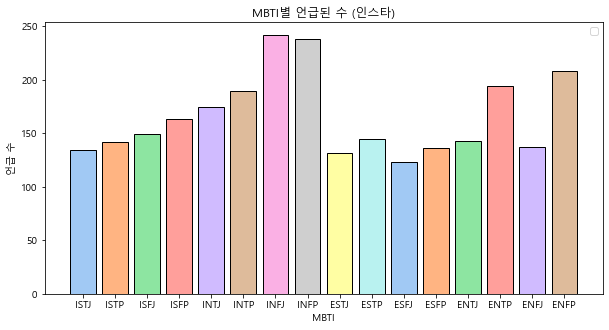

In [27]:
# 그래프 그리기
mbti = []
n = []
for i in range(0,len(count)):
    mbti.append(count[i][0])
    n.append(count[i][1])

plot2(mbti,n,'MBTI별 언급된 수 (인스타)','bar','MBTI','언급 수')

In [14]:
# DB 데이터 조회 불러오기 (INFJ, INFP, ENFP)
top3 = ['infj', 'infp', 'enfp']
idx = 0

top3_df = pd.DataFrame(columns=['mbti','전체게시물', '좋아요 게시물', '1000개이상', '500개이상',  '500개미만'])

for m in top3:
    try:
        cur.execute(f"select * from public.insta_{m};")
        conn.commit()
        mbti_kind = cur.fetchall()
        
        n1,n2,n3 = 0,0,0 # n1 : 1000개이상 n2 : 500개이상 n3 : 나머지
        for i in range(0,len(mbti_kind)):
            # like의 형태가 '좋아요 1,245개'이므로, 1245 형태로 변환 작업 실시 
            if '좋' in mbti_kind[i][3]:
                if int(mbti_kind[i][3][4:-1].replace(',','')) > 999:
                    n1 += 1
                elif int(mbti_kind[i][3][4:-1].replace(',','')) > 499:
                    n2 += 1
                else:
                    n3 += 1
        top3_df.loc[idx] = [m,len(mbti_kind),(n1+n2+n3),n1,n2,n3,]
        idx += 1
          
    except:
        conn.rollback()
        print("--- DB error")

mbti_kind[0][3]

'좋아요 1,245개'

In [36]:
전체대비좋아요 = []
좋아요대비1000 = []
좋아요대비500 = []

# 좋아요 변수 정의 (반올림 작업)
for i in range(0,len(top3_df)):
    a1 = round((top3_df.iloc[i][2]/top3_df.iloc[i][1]*100), 2)
    a2 = round((top3_df.iloc[i][3]/top3_df.iloc[i][1]*100), 2)
    a3 = round(((top3_df.iloc[i][3]+top3_df.iloc[i][4])/top3_df.iloc[i][2]*100), 2)

    전체대비좋아요.append(a1)
    좋아요대비1000.append(a2)
    좋아요대비500.append(a3)

# Dataframe 열 추가
top3_df['전체대비좋아요']=전체대비좋아요
top3_df['좋아요대비1000']=좋아요대비1000
top3_df['좋아요대비500']=좋아요대비500

top3_df

,mbti,전체게시물,좋아요 게시물,1000개이상,500개이상,500개미만,전체대비좋아요,좋아요대비1000,좋아요대비500
0,infj,480,373,37,39,297,77.71,7.71,20.38
1,infp,491,415,43,27,345,84.52,8.76,16.87
2,enfp,495,433,25,29,379,87.47,5.05,12.47


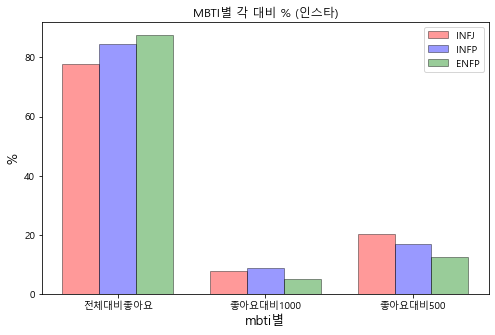

In [39]:
## 그래프 그리기
import matplotlib.pyplot as plt
import numpy as np

# 그림 사이즈, 바 굵기 조정
plt.figure(figsize=(8,5))
bar_width = 0.25

# MBTI가 3개이므로 0, 1, 2 위치를 기준으로 삼음
index = np.arange(3)

# 각 변수별로 3개 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
b1 = plt.bar(index, list(top3_df.loc[0][6:]), bar_width, alpha=0.4, color='red', label='INFJ',edgecolor='black')

b2 = plt.bar(index + bar_width, list(top3_df.loc[1][6:]), bar_width, alpha=0.4, color='blue', label='INFP',edgecolor='black')

b3 = plt.bar(index + 2 * bar_width, list(top3_df.loc[2][6:]), bar_width, alpha=0.4, color='green', label='ENFP',edgecolor='black')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
plt.xticks(np.arange(bar_width, 3 + bar_width, 1), ['전체대비좋아요','좋아요대비1000','좋아요대비500'])

# x축, y축 이름 및 범례 설정
plt.xlabel('mbti별', size = 13)
plt.ylabel('%', size = 13)
plt.title('MBTI별 각 대비 % (인스타)')
plt.legend()

### 도서 API

In [30]:
client_id = "SFBVy_Sps38LXkNxHNoq"
client_secret = "zlixlrNhi3"

query = urllib.parse.quote(input('검색할 단어'))
display = 100
start = 1
end = 1000
idx = 0
sort = 'sim'

df = pd.DataFrame(columns=['Title', 'Link',  'Publisher', 'Isbn', 'Pubdate', 'Description'])

for start_index in range(start, end, display):
    url = "https://openapi.naver.com/v1/search/book?query=" + query + \
        "&display=" + str(display) + \
        "&start=" + str(start_index) + \
        "&sort=" + sort
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if (rescode == 200):
        response_body = response.read()
        items = json.loads(response_body.decode('utf-8'))["items"]
        remove_tag = re.compile('<.*?>')
        for item_index in range(0, len(items)):
            title = re.sub(remove_tag, '', items[item_index]['title']) # 제목
            link = items[item_index]['link'] # 하이퍼텍스트 link
            image = items[item_index]['image'] # 썸네일 이미지의 URL
            author = items[item_index]['author'] # 저자
            price = items[item_index]['price'] # 정가
            discount = items[item_index]['discount'] # 할인가격
            publisher = items[item_index]['publisher'] # 출판사
            isbn = items[item_index]['isbn'] # 국제표준도서번호(ISBN) 넘버
            description = re.sub(remove_tag, '', items[item_index]['description']) # 검색결과 문서의 내용 요약
            pubdate = items[item_index]['pubdate'] # 출간일

            df.loc[idx] = [title, link, publisher, isbn, pubdate, description]
            idx += 1
    else:
        print("Error Code: " + rescode)

df.loc[0:3]

,Title,Link,Publisher,Isbn,Pubdate,Description
0,흔한남매 흔한 MBTI (믿거나 말거나 나에게 어울리는 직업),http://book.naver.com/bookdb/book_detail.php?b...,대원키즈,1136273794 9791136273796,20210901,흔한남매와 함께 떠나는MBTI 유형별 직업 여행『흔한 MBTI』는 널리 알려진 MB...
1,우리들의 MBTI (나의 성격을 이해하고 더 멋진 내가 되는),http://book.naver.com/bookdb/book_detail.php?b...,다산어린이,1130639401 9791130639406,20210726,MBTI는 성격 유형마다 타고난 강점을 활용하고 단점을 보완하면서 성장할 수 있는 ...
2,나의 MBTI가 궁금하단 마리몽,http://book.naver.com/bookdb/book_detail.php?b...,더모던,1164455354 9791164455355,20211130,"여러분의 MBTI는 무엇입니까?\n\n혈액형 A형은 소심하고, O형은 활발하다고 유..."
3,MBTI의 의미 (MBTI는 과학인가?),http://book.naver.com/bookdb/book_detail.php?b...,하움출판사,1164407112 9791164407118,20201119,&quot;MBTI는 과학적인가?&quot; 이 질문에 대한 나의 대답은 이것이다....


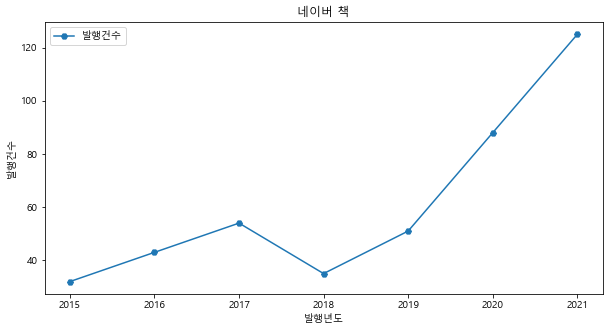

In [34]:
# 데이터 정제
date = {'2015':0,'2016':0,'2017':0,'2018':0,'2019':0,'2020':0,'2021':0}
date_k = list(date.keys())

for i in range(0,len(df)):
    for j in range(0,len(date_k)):
        if date_k[j] in df['Pubdate'][i]:
            date[date_k[j]] += 1

date_v = list(date.values())

# 그래프 그리기
plot2(date_k, date_v, '네이버 책','line','발행년도','발행건수')